## Table of Contents <a class = "anchor" id = "toc"></a>
* [Data Exploration](#exploration)

# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('punkt')
nltk.download('opinion_lexicon')
nltk.download('wordnet')
nltk.download('stopwords')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

from tqdm import tqdm
from gensim.models import Word2Vec

from sklearn.metrics import roc_curve, roc_auc_score, f1_score, classification_report, auc
from sklearn.model_selection import cross_val_predict, StratifiedKFold, train_test_split, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.models import Model

from sentence_transformers import SentenceTransformer
from langdetect import detect
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import emoji
import langid
import regex
import string

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/catarinasilva/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/catarinasilva/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/catarinasilva/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/catarinasilva/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Data Exploration <a class = "anchor" id = "exploration"></a>
[Back to the Table of Contents](#toc)

In [2]:
%%time
airbnb_train = pd.read_excel('../data/train.xlsx')
airbnb_train_reviews = pd.read_excel('../data/train_reviews.xlsx')
airbnb_test = pd.read_excel('../data/test.xlsx')
airbnb_test_reviews = pd.read_excel('../data/test_reviews.xlsx')

CPU times: user 7.7 s, sys: 178 ms, total: 7.88 s
Wall time: 8.01 s


In [3]:
airbnb_train.head(5)

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0


In [4]:
airbnb_train_reviews.head(5)

,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."
3,1,Das Hostel war neu und deshalb funktionierte a...
4,1,"It was fine for a dorm, but I think for the pe..."


In [5]:
airbnb_test.head(5)

,index,description,host_about
0,1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de..."
1,2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...
2,3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ..."
3,4,Charming Apartment Close to the Bay of Cascais...,:)
4,5,"Se procura umas férias perto da praia, casino ...",Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...


In [6]:
airbnb_test_reviews.head(5)

,index,comments
0,1,Thank you very much Antonio ! All has been per...
1,1,Very nice appartment in the old town of Lissab...
2,1,When travelling we're looking for kids friendl...
3,1,We've been in Lisbon in march 2013 (3 adults a...
4,1,Our host Antonio was very helpful with informa...


* The results above show that we have comments in languages other than English (e.g., Portuguese, French, and German). We can install paid (e.g., Google and Microsoft) and free (e.g., LibreTranslate) APIs to translate those comments into English. However, I don't know if we can use them.

In [7]:
print(f"The data frame airbnb_train has : {len(airbnb_train)} rows")
print(f"The data frame airbnb_train_reviews has : {len(airbnb_train_reviews)} rows")
print()
print(f"The data frame airbnb_test has : {len(airbnb_test)} rows")
print(f"The data frame airbnb_test_reviews has : {len(airbnb_test_reviews)} rows")

The data frame airbnb_train has : 6248 rows
The data frame airbnb_train_reviews has : 361281 rows

The data frame airbnb_test has : 695 rows
The data frame airbnb_test_reviews has : 41866 rows


In [8]:
airbnb_train.dtypes

index           int64
description    object
host_about     object
unlisted        int64
dtype: object

In [9]:
airbnb_train.isna().sum()

index          0
description    0
host_about     0
unlisted       0
dtype: int64

In [10]:
airbnb_train_reviews.isna().sum()

index       0
comments    2
dtype: int64

In [11]:
airbnb_train_reviews.dropna(subset=['comments'], inplace=True)
airbnb_train_reviews['comments'].isna().sum()

0

In [12]:
airbnb_test.isna().sum()

index          0
description    0
host_about     0
dtype: int64

In [13]:
airbnb_test_reviews.isna().sum()

index       0
comments    0
dtype: int64

In [14]:
airbnb_train['unlisted'].value_counts(normalize = True)*100

unlisted
0    72.663252
1    27.336748
Name: proportion, dtype: float64

* The training dataset has a predominant value of 0. Perhaps we should consider ways to balance the dataset (e.g., oversampling).

In [15]:
airbnb_train['unlisted'].describe()

count    6248.000000
mean        0.273367
std         0.445724
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: unlisted, dtype: float64

In [16]:
print(airbnb_train_reviews.duplicated().sum())
duplicates = airbnb_train_reviews.duplicated()
airbnb_train_reviews[duplicates]

142


,index,comments
3254,61,Excelente!
4263,70,Everything was great!
6586,144,"Sofia is an incredible host, and made us feel ..."
7362,156,.
12962,254,.
...,...,...
353155,6099,.
353252,6099,Amazing house
353703,6106,Super
358568,6182,Great location!


In [17]:
airbnb_train_reviews['comments'].value_counts(dropna = False)

comments
.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

* Perhaps we must find ways to combine the comments and description files before splitting the dataset into train and validation sets.
* Handling duplicates and missing values may be good before combining the datasets.

### Word count

#### Train reviews

In [18]:
airbnb_train_reviews['word_count']  = airbnb_train_reviews['comments'].apply(lambda x: len(str(x).split(" ")))
airbnb_train_reviews[['comments','word_count']].head()

,comments,word_count
0,this is a very cozy and comfortable house to s...,28
1,good<br/>,1
2,"My first hostel experience, and all I have to ...",261
3,Das Hostel war neu und deshalb funktionierte a...,81
4,"It was fine for a dorm, but I think for the pe...",27


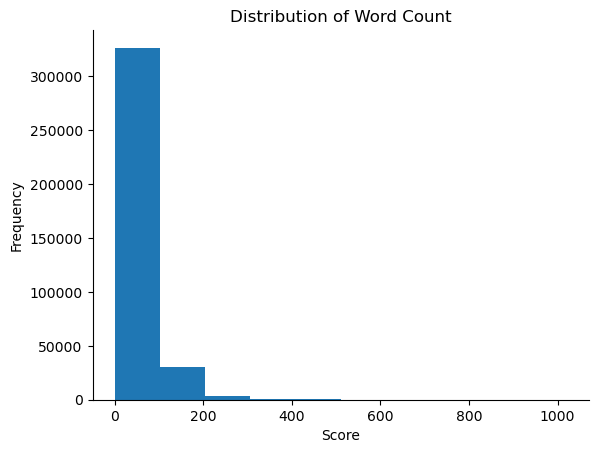

In [19]:
airbnb_train_reviews['word_count'].hist()
plt.grid(False)  
plt.title('Distribution of Word Count')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

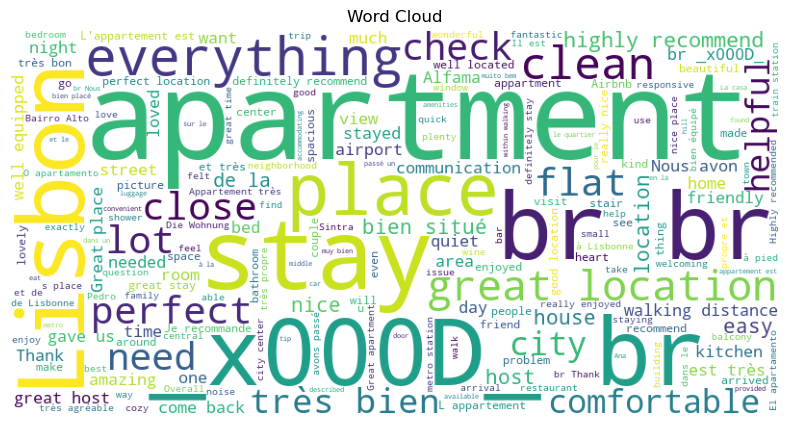

In [20]:
from wordcloud import WordCloud 
all_reviews = ' '.join(airbnb_train_reviews['comments'])
    
# Create WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_reviews)

#Plotting the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Word Cloud')
plt.show()

#### Test reviews

In [21]:
airbnb_test_reviews['word_count']  = airbnb_test_reviews['comments'].apply(lambda x: len(str(x).split(" ")))
airbnb_test_reviews[['comments','word_count']].head()

,comments,word_count
0,Thank you very much Antonio ! All has been per...,33
1,Very nice appartment in the old town of Lissab...,41
2,When travelling we're looking for kids friendl...,97
3,We've been in Lisbon in march 2013 (3 adults a...,49
4,Our host Antonio was very helpful with informa...,131


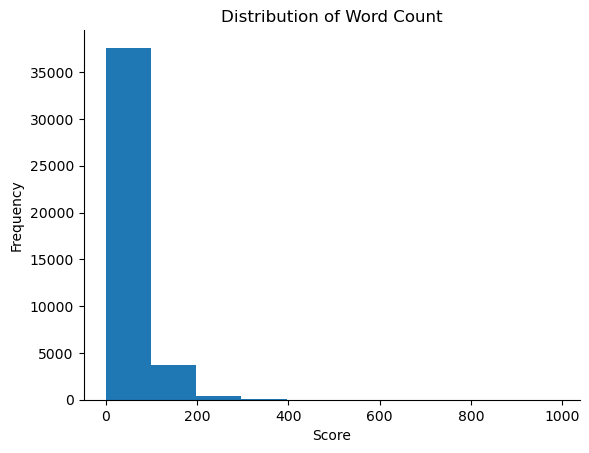

In [22]:
airbnb_test_reviews['word_count'].hist()
plt.grid(False)  
plt.title('Distribution of Word Count')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

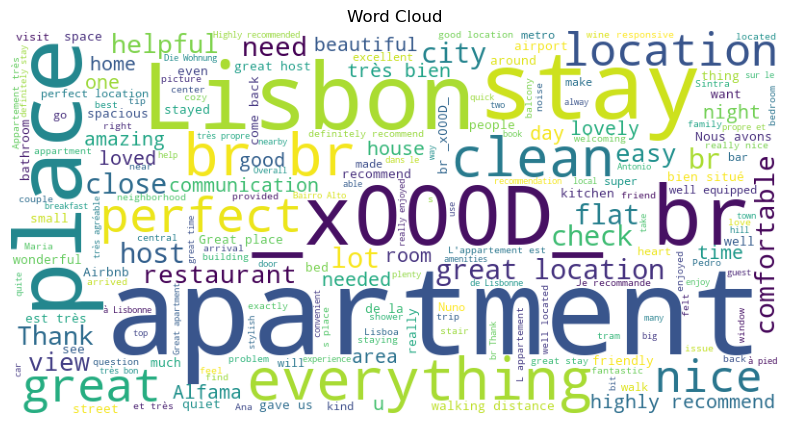

In [23]:
from wordcloud import WordCloud 
all_reviews = ' '.join(airbnb_test_reviews['comments'])
    
# Create WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_reviews)

#Plotting the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Word Cloud')
plt.show()

# Results Exploration

In [34]:
train_reviews = pd.read_csv("../data/cleaned/train_reviews_vf.csv")
test_reviews = pd.read_csv("../data/cleaned/test_reviews_vf.csv")

train= pd.read_csv("../data/cleaned/train_vf.csv")
test= pd.read_csv("../data/cleaned/test_vf.csv")

Final data exploration after the data was preprocessed and cleaned

In [26]:
def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

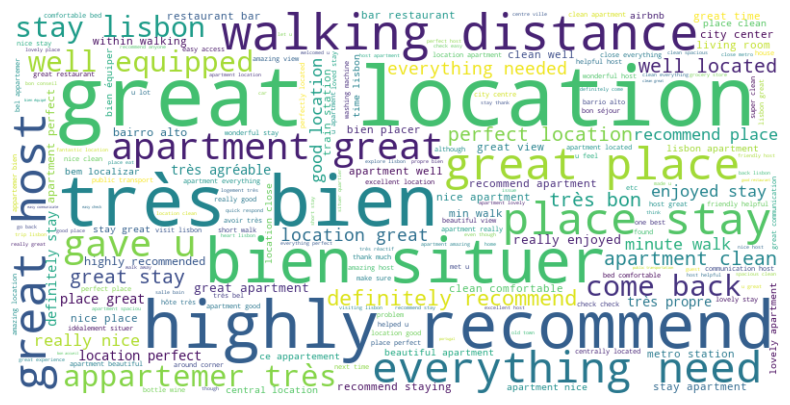

In [27]:
train_reviews_ = " ".join(train_reviews['cleaned_comments'])
generate_wordcloud(train_reviews_)

In [28]:
train_reviews_words = " ".join(train_reviews['cleaned_comments']).split()
freq_train_rev = pd.Series(train_reviews_words).value_counts()
freq_train_rev.sort_values(ascending=False)[0:10]

apartment    157185
great        140443
place        109698
stay         105076
location     104508
lisbon        78501
très          74478
u             73384
host          72452
nice          66595
Name: count, dtype: int64

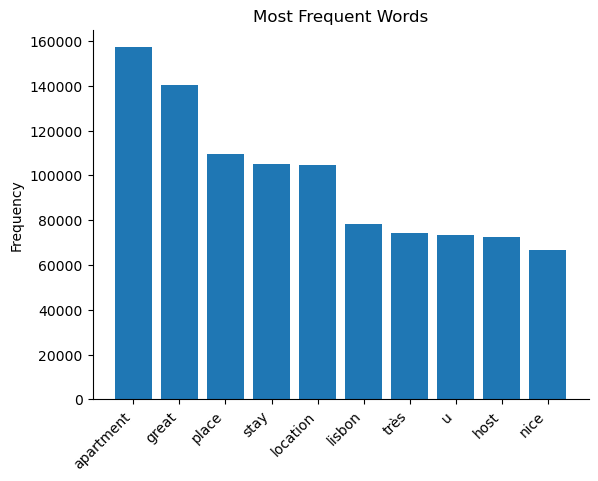

In [29]:
x_labels = freq_train_rev.index[0:10]
values = freq_train_rev[:10]
plt.bar(x_labels, values)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel('Frequency')
plt.title('Most Frequent Words')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

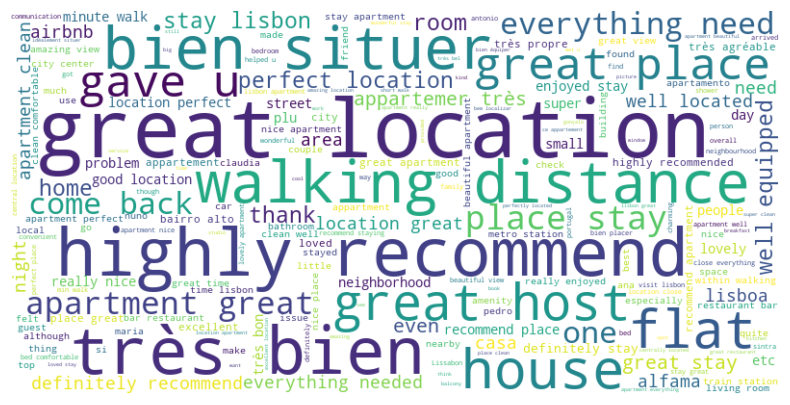

In [30]:
test_reviews_ = " ".join(test_reviews['cleaned_comments'])
generate_wordcloud(test_reviews_)

In [31]:
test_reviews_words = " ".join(test_reviews['cleaned_comments']).split()
freq_test_rev = pd.Series(test_reviews_words).value_counts()
freq_test_rev.sort_values(ascending=False)[0:10]

apartment    18626
great        16701
place        12952
location     12336
stay         12275
lisbon        9587
u             9057
host          8326
très          8063
clean         7697
Name: count, dtype: int64

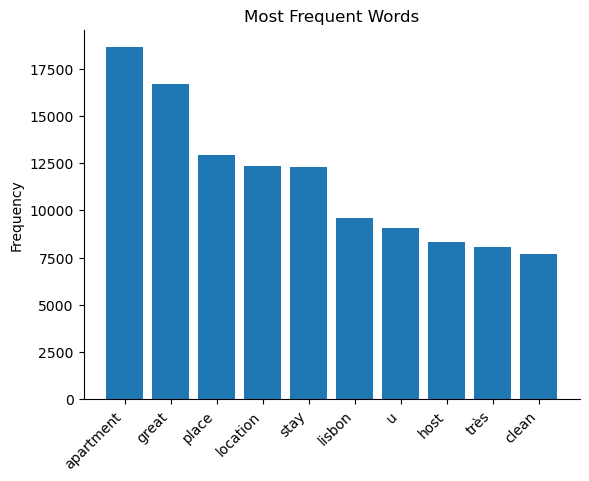

In [32]:
x_labels = freq_test_rev.index[0:10]
values = freq_test_rev[:10]
plt.bar(x_labels, values)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel('Frequency')
plt.title('Most Frequent Words')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

#### host

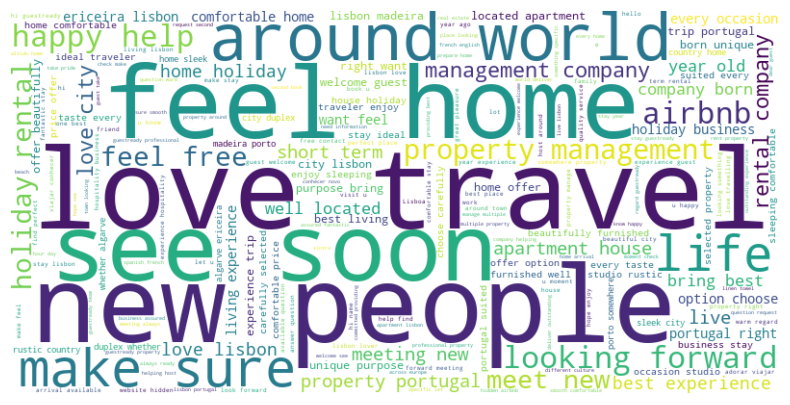

In [35]:
train_host_ = " ".join(train['cleaned_host'])
generate_wordcloud(train_host_)

In [36]:
train_host_ = " ".join(train['cleaned_host']).split()
freq_host = pd.Series(train_host_).value_counts()
freq_host.sort_values(ascending=False)[0:10]

lisbon        4136
love          2717
home          2275
apartment     1976
stay          1949
guest         1933
experience    1917
portugal      1802
city          1785
like          1662
Name: count, dtype: int64

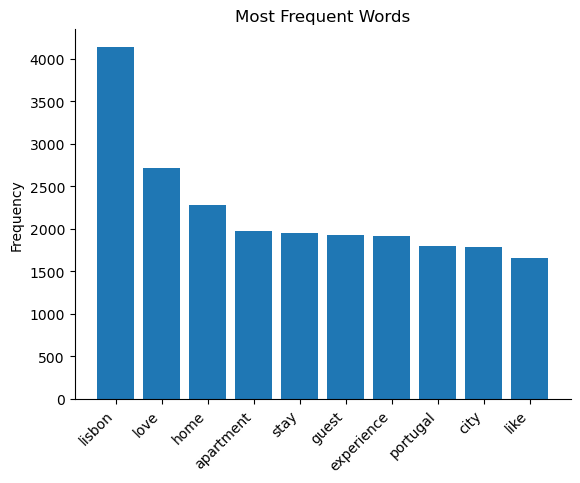

In [37]:
x_labels = freq_host.index[0:10]
values = freq_host[:10]
plt.bar(x_labels, values)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel('Frequency')
plt.title('Most Frequent Words')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

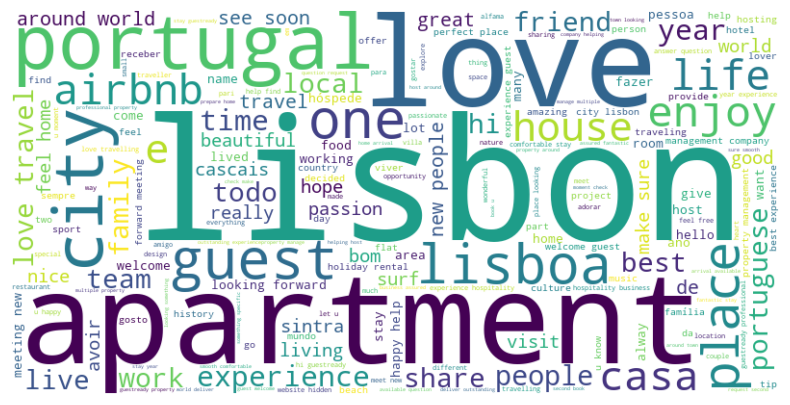

In [38]:
test_host_ = " ".join(test['cleaned_host'])
generate_wordcloud(test_host_)

In [39]:
test_host_ = " ".join(test['cleaned_host']).split()
freq_host = pd.Series(test_host_).value_counts()
freq_host.sort_values(ascending=False)[0:10]

lisbon        485
love          315
home          270
stay          258
guest         233
apartment     231
experience    217
like          202
city          200
portugal      181
Name: count, dtype: int64

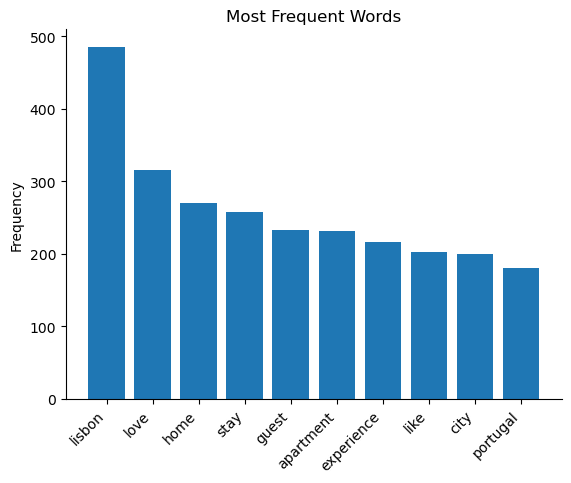

In [40]:
x_labels = freq_host.index[0:10]
values = freq_host[:10]
plt.bar(x_labels, values)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel('Frequency')
plt.title('Most Frequent Words')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

#### property description

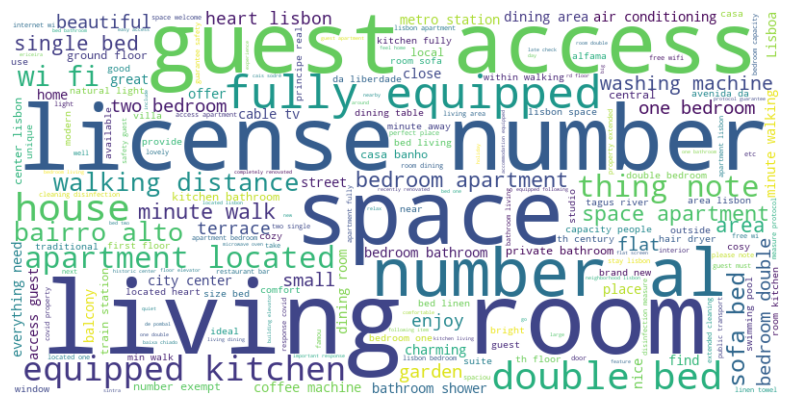

In [41]:
train_dcp_ = " ".join(train['cleaned_description'])
generate_wordcloud(train_dcp_)

In [42]:
train_dcp_ = " ".join(train['cleaned_description']).split()
freq_dcp = pd.Series(train_dcp_).value_counts()
freq_dcp.sort_values(ascending=False)[0:10]

apartment    9360
lisbon       6297
space        5996
room         5771
bedroom      4742
bed          4196
guest        3915
located      3881
kitchen      3685
bathroom     3245
Name: count, dtype: int64

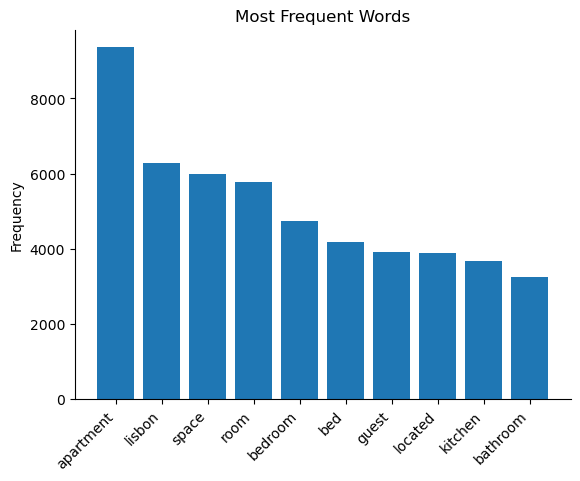

In [43]:
x_labels = freq_dcp.index[0:10]
values = freq_dcp[:10]
plt.bar(x_labels, values)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel('Frequency')
plt.title('Most Frequent Words')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

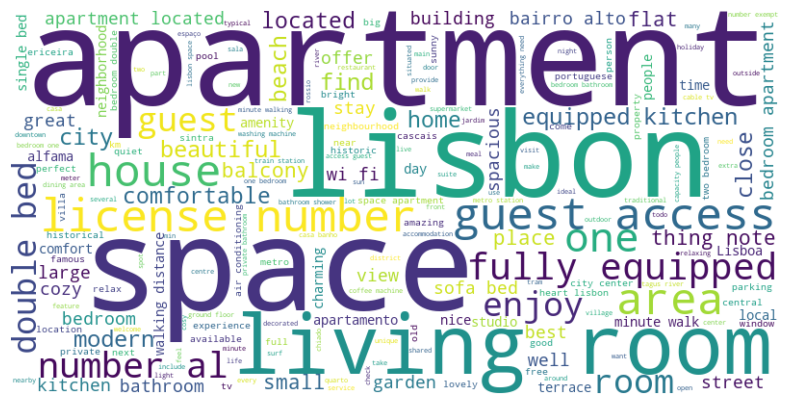

In [44]:
test_dcp_ = " ".join(test['cleaned_description'])
generate_wordcloud(test_dcp_)

In [45]:
test_dcp_ = " ".join(test['cleaned_description']).split()
freq_dcp = pd.Series(test_dcp_).value_counts()
freq_dcp.sort_values(ascending=False)[0:10]

apartment    1075
lisbon        703
space         694
room          679
bedroom       580
bed           514
guest         488
kitchen       456
located       433
one           431
Name: count, dtype: int64

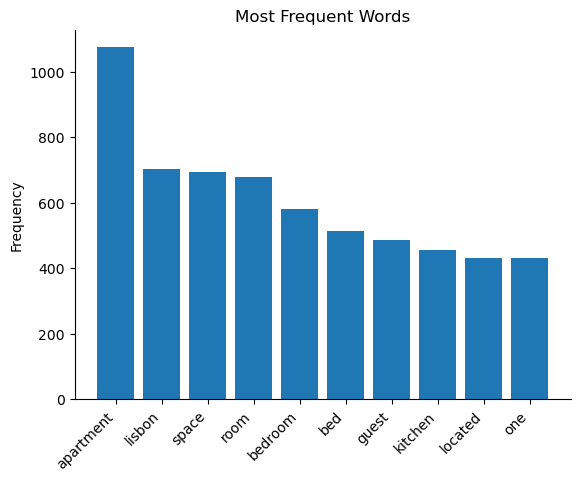

In [46]:
x_labels = freq_dcp.index[0:10]
values = freq_dcp[:10]
plt.bar(x_labels, values)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel('Frequency')
plt.title('Most Frequent Words')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()